# GEODOS data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [2]:
fto = '/storage/experiments/2021/03_REFLECT3/AirdosCvetsiNaITl_9c/DATALOG.TXT' #  File to Open
fto = '/storage/experiments/2021/0609_bourka_sobeslav/GEODOS/BF/DATALOG.TXT' #  File to Open
#fto = '/storage/experiments/2021/0605_bourka_radosovice/GEODOS/BF/DATALOG.TXT' #  File to Open
fto = '/storage/experiments/2021/10_test_geodos_cernobyl/DATALOG.TXT'
fto = '/storage/experiments/2021/10_test_geodos_cernobyl/Na22/DATALOG.TXT'
fto = '/storage/experiments/2021/10_test_geodos_cernobyl/background_odz/DATALOG.TXT'
#fto = '/storage/experiments/2021/10_test_geodos_cernobyl/balon_background_odz/DATALOG.TXT'
fto = '/storage/stations/Cernobyl/let04.10.2021/DATALOG.TXT'
fto = '/storage/stations/Cernobyl/06102021/DATALOG.TXT'
fto = '/storage/stations/Cernobyl/17.10.2021/DATALOG.TXT'
fto = '/storage/stations/Cernobyl/28.10.21_8.55/DATALOG.TXT'
#fto = '/storage/stations/Cernobyl/04.11.2021_7.30/DATALOG.TXT'
fto = '/storage/stations/Cernobyl/15.11.2021_15.10/DATALOG.TXT'
    
l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn.iloc[0])
print ('f.v.: ',fw.iloc[0])
print(df.loc[df[0]=='$AIRDOS',1].iloc[0])
print(len(df))
print(last[-1:][0])

df.drop(df.index[:last[-1:][0]], inplace=True) # keep only last run

s.n.:  1290c00806a200923c12a000a00000bf
f.v.:  a1bf671
CERNOBYL
394919
286628


## Fill position and time

## Galileo support

In [3]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GPGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.loc[df[0]=='$HIST',1]
df = df.fillna(method='ffill')
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
df.drop('date', axis=1, inplace=True)
df.drop('miliseconds', axis=1, inplace=True)
df.drop('on_miliseconds', axis=1, inplace=True)
df


,0,1,2,3,4,5,6,7,8,9,...,495,496,497,498,499,alt,lat,lon,meas,UTC
286808,$HIST,79,1436.50,100689.00,1.19,3.85,-18,497,948,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79,NaT
286809,$HITS,0,1436.50,100689.00,1.19,3.85,-18,497,948,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79,NaT
286810,$HIST,80,1454.17,100685.75,1.19,3.85,-18,497,948,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,NaT
286811,$HITS,0,1454.17,100685.75,1.19,3.85,-18,497,948,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,NaT
286812,$HIST,81,1471.82,100684.50,1.19,3.85,-18,497,948,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395155,$HITS,0,977687.25,102264.25,0.31,3.65,-20,0,875,-1.15,...,NaN,NaN,NaN,NaN,NaN,NaN,51.386198,30.064046,54147,2021-11-15 13:01:04.790
395156,$HIST,54148,977705.42,102266.50,0.31,3.65,-20,0,875,-1.15,...,NaN,NaN,NaN,NaN,NaN,NaN,51.386198,30.064046,54148,2021-11-15 13:01:22.960
395157,$HITS,0,977705.42,102266.50,0.31,3.65,-20,0,875,-1.15,...,NaN,NaN,NaN,NaN,NaN,NaN,51.386198,30.064046,54148,2021-11-15 13:01:22.960
395158,$HIST,54149,977723.58,102259.75,0.25,3.65,-20,0,875,-1.25,...,NaN,NaN,NaN,NaN,NaN,NaN,51.386198,30.064046,54149,2021-11-15 13:01:41.120


## Add individual events to histogram

In [8]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:270].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,12:269] = 0
hist.set_index('meas', inplace=True)
hits = df.loc[df[0]=='$HITS'].copy()
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits.set_index('meas', inplace=True)


In [5]:
for index, row in hits.iterrows():
    for j in range(2,2+row[1]*2,2):
        hist.loc[index,int(row[j+1])+3] += 1


In [6]:
df.iloc[:,10:30]

,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
3923,40476,25037.0,5,3.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3924,40476,25037.0,5,3.0,5.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3925,41866,23651.0,3,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3926,41866,23651.0,3,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3927,42218,23292.0,7,3.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6922,47667,17848.0,4,5.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6923,45260,20252.0,5,3.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6924,45260,20252.0,5,3.0,5.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6925,46455,19053.0,7,3.0,5.0,2.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.drop(df[df[0]=='$HITS'].index, inplace=True)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df.drop(df[df[0]=='$GNVTG'].index, inplace=True)
df.drop(df[df[0]=='$GNGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNGSA'].index, inplace=True)
df.drop(df[df[0]=='$GNGSV'].index, inplace=True)
df.drop(df[df[0]=='$GNGLL'].index, inplace=True)
df.drop(df[df[0]=='$GLGSV'].index, inplace=True)

df.loc[df[0]!='$HIST']

,0,1,2,3,4,5,6,7,8,9,...,496,497,498,499,alt,lat,lon,meas,UTC,flux


In [4]:
NOISE_LEVEL = 12
LAST_CHANNEL = 250
df['flux'] = (df.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

Text(0, 0.5, 'Counts')

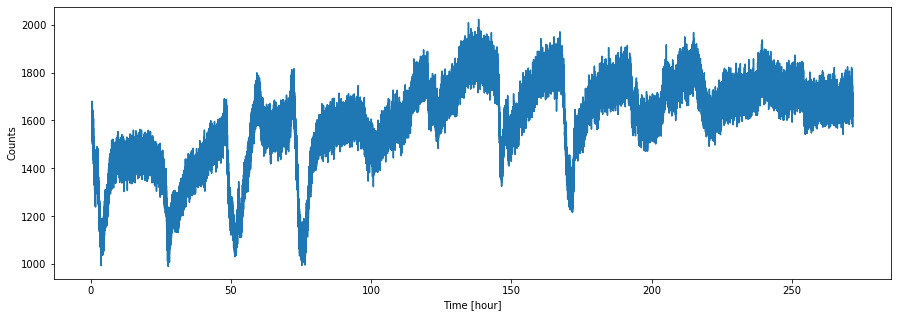

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df[2].astype('float')/60/60,df['flux'])
#plt.locator_params(nbins=10)
#plt.ylim([0,250])
plt.xlabel('Time [hour]')
plt.ylabel('Counts')


Text(0, 0.5, 'Counts')

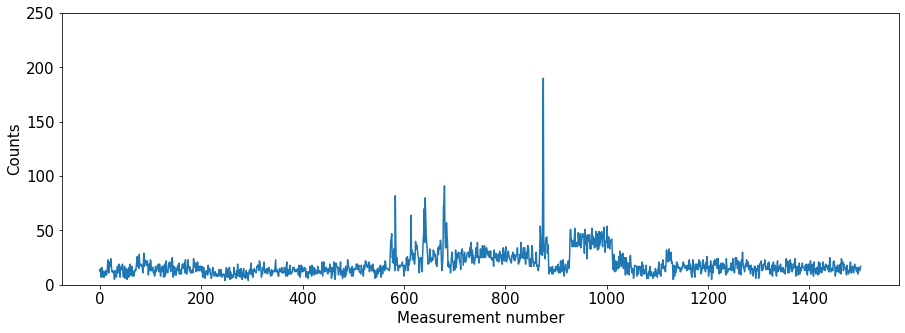

In [39]:
plt.figure(figsize=(15,5))
plt.plot(df[1].astype('float'),df['flux'])
#plt.locator_params(nbins=10)
plt.ylim([0,250])
plt.xlabel('Measurement number')
plt.ylabel('Counts')


In [34]:
xx = df
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc['2021-11-13 18:00:00':'2021-11-13 23:00:00']
xx = xx.iloc[:,12:250].astype('float')
ener1 = xx.iloc[:,:].sum()
#ener1 = xx.iloc[-1000:,:].sum()
e = pd.DataFrame()
e['1'] = ener1
e['index'] = pd.to_numeric(ener1.index)
e.set_index('index',inplace=True)

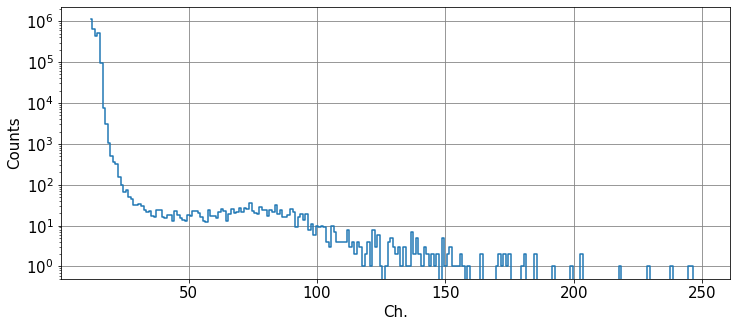

In [35]:
plt.figure(figsize=(12,5))
plt.plot(ener1, drawstyle='steps-mid')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
plt.grid(b=True, which='major', color='grey', linestyle='-')
#plt.xlim([10,100])

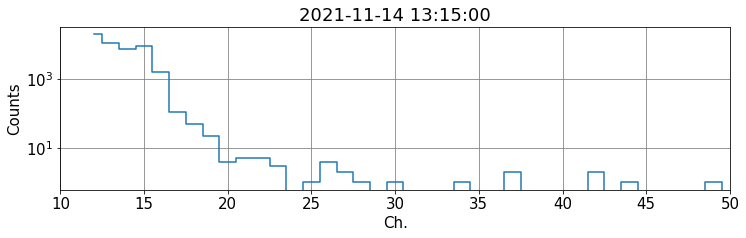

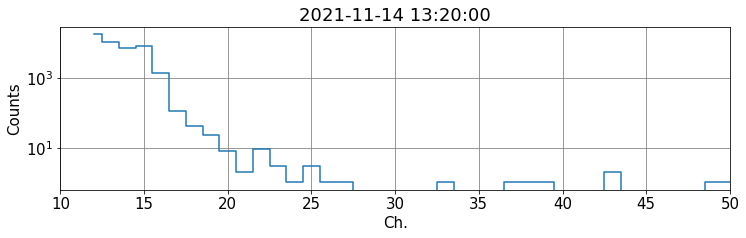

In [30]:
rozsah = pd.date_range('2021-11-14 13:15:00', '2021-11-14 13:20:00', freq='5T')
for time in rozsah:
    xx = df.loc[time:time+pd.Timedelta(minutes=5)]
    xx = xx.iloc[:,12:250].astype('float')
    ener1 = xx.iloc[:,:].sum()
    #ener1 = xx.iloc[-1000:,:].sum()
    e = pd.DataFrame()
    e['1'] = ener1
    e['index'] = pd.to_numeric(ener1.index)
    e.set_index('index',inplace=True)
    
    plt.figure(figsize=(12,3))
    plt.plot(ener1, drawstyle='steps-mid')
    plt.yscale('log')
    plt.xlabel('Ch.')
    plt.ylabel('Counts')
    plt.title(str(time))
    plt.grid(b=True, which='major', color='grey', linestyle='-')
    plt.xlim([10,50])

In [134]:
pd.date_range('2021-10-05 15:00:00', '2021-10-05 16:00:00', freq='5T') + pd.Timedelta(minutes=5)

DatetimeIndex(['2021-10-05 15:05:00', '2021-10-05 15:10:00',
               '2021-10-05 15:15:00', '2021-10-05 15:20:00',
               '2021-10-05 15:25:00', '2021-10-05 15:30:00',
               '2021-10-05 15:35:00', '2021-10-05 15:40:00',
               '2021-10-05 15:45:00', '2021-10-05 15:50:00',
               '2021-10-05 15:55:00', '2021-10-05 16:00:00',
               '2021-10-05 16:05:00'],
              dtype='datetime64[ns]', freq='5T')

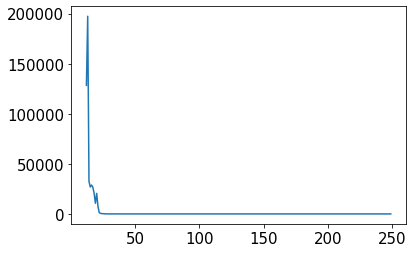

In [213]:
#xx.iloc[-2:,12:30]
#ener1 = xx.iloc[-2:,:250].sum()

#xx
#ener1
#xx.iloc[100:200,NOISE_LEVEL:250]
#e[0:]
#print(xx.iloc[-2:,12:30])
plt.plot(ener1)
#xx.iloc[:,0:250]

## Plot Flux

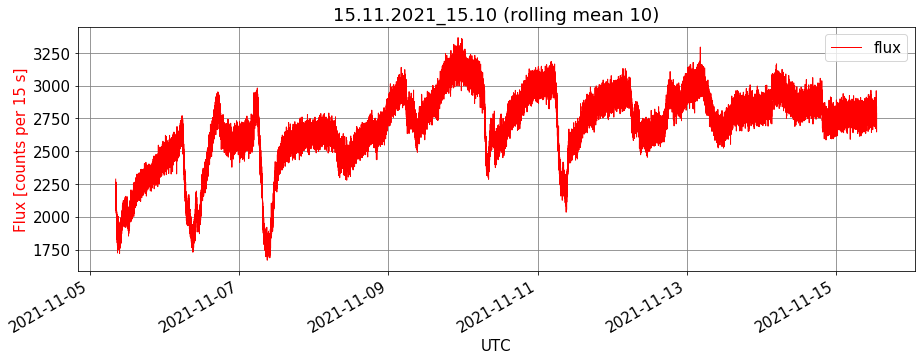

In [27]:
NOISE_LEVEL = 12
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-10-05 14:00:00':'2021-10-05 14:30:00']
#xx = xx.loc['2021-10-05 13:00:00':'2021-10-05 16:00:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']


xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='red', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='red')
plt.legend(loc=2)

'''
ax = plt.twinx()

#plt.ylim([0,14000])
#xx['alt'].plot(c='b', label='alt', marker='.', ms=2, linewidth='2', linestyle='none', drawstyle='steps-mid')
xx['alt'].plot(c='b', label='alt', marker='.', ms=2, linewidth='2', drawstyle='steps-mid')
plt.ylabel('altitude a.s.l. [m]', color='blue')
'''
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



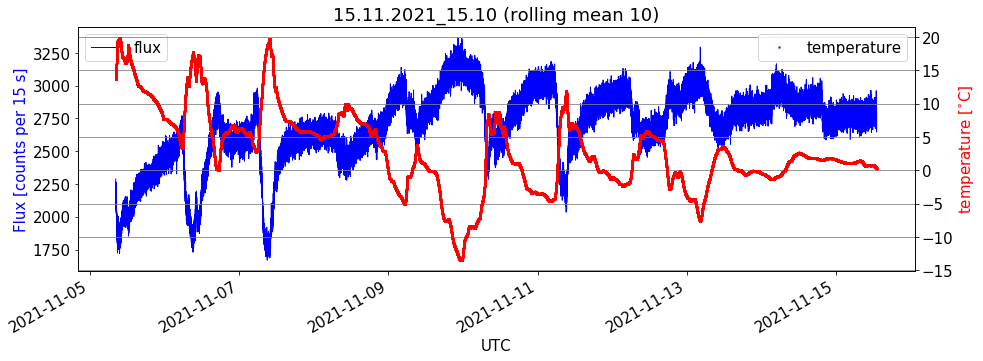

In [21]:
NOISE_LEVEL = 12
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



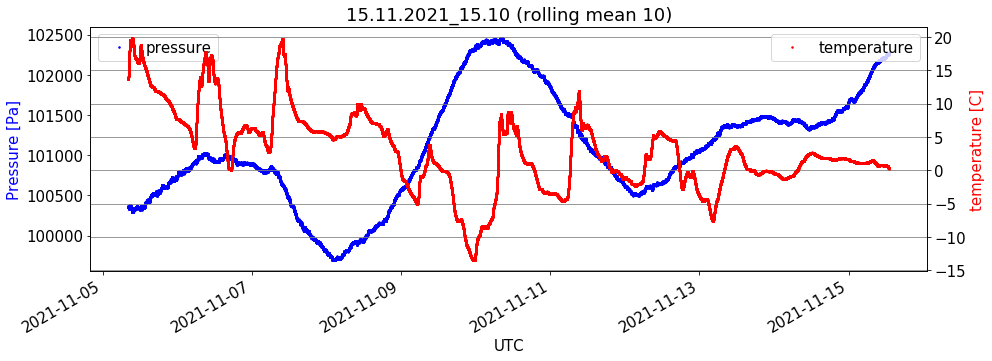

In [11]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[4].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



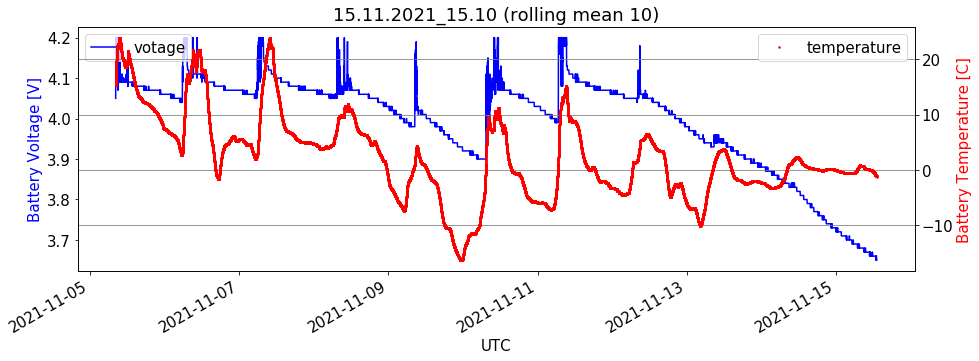

In [12]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']

#xx[5].plot(c='blue', linestyle='-', marker='.', ms=3, label = 'pressure')
xx[5].plot(c='blue', label = 'votage')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Battery Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[9].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Battery Temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


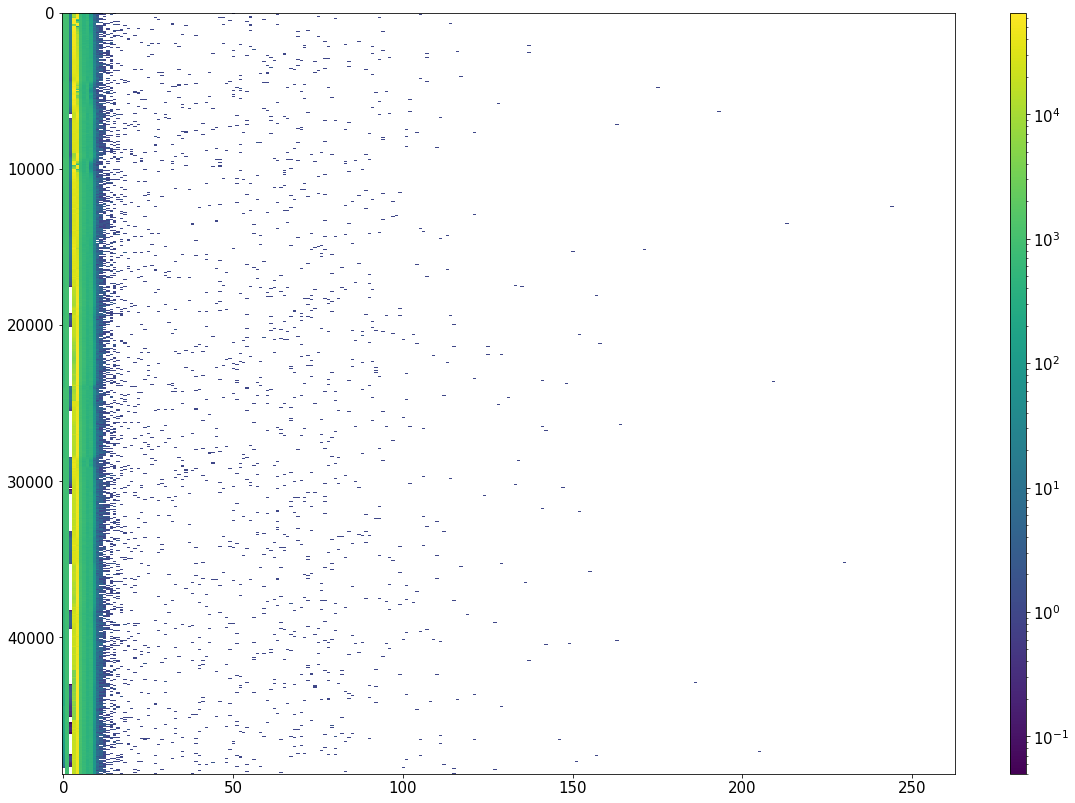

In [22]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((hist.iloc[:,7:270]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

In [16]:

hist['2021-03-24 13:00:00':'2021-03-24 13:01:00'].iloc[:,7:]


,7,8,9,10,11,12,13,14,15,16,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-03-24 13:00:19.550,10,6,2,4,3.0,2,1,1,1,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:19.550,91.0,97.0
2021-03-24 13:00:29.050,6,8,5,3,5.0,1,1,0,3,3,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:29.050,110.0,98.0
2021-03-24 13:00:38.800,6,7,3,3,3.0,3,4,0,2,0,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:38.800,90.0,98.1
2021-03-24 13:00:48.140,10,7,9,8,3.0,2,3,0,3,2,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:48.140,101.0,98.0
2021-03-24 13:00:57.710,10,8,2,5,4.0,1,2,2,1,1,...,0,0,0,NaN,12037.0,50.257991,15.868048,2021-03-24 13:00:57.710,106.0,99.5


In [240]:
# balon
#xx = df.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
xx = df
xx = xx.iloc[1:,14:250].astype('float')
ener1 = xx.iloc[100:1000,:].sum()
#ener1 = xx.iloc[-1000:,:].sum()
e = pd.DataFrame()
e['1'] = ener1
e['index'] = pd.to_numeric(ener1.index)
e.set_index('index',inplace=True)

In [56]:
df.set_index('UTC', inplace=True)

In [189]:
df.loc['2021-10-09 22:00:00':'2021-10-10 02:00:00']
df

,0,1,2,3,4,5,6,7,8,9,...,496,497,498,499,alt,lat,lon,meas,UTC,flux
17772,$HIST,5400,89046.67,102611.00,11.75,4.05,-7,646,953,8.95,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,5400,2021-10-08 06:52:49.480,1370.0
17774,$HIST,5401,89063.41,102607.50,11.81,4.17,23,646,952,9.05,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,5401,2021-10-08 06:53:06.220,1407.0
17776,$HIST,5402,89079.85,102602.75,11.88,4.16,14,646,952,9.05,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,5402,2021-10-08 06:53:22.660,1407.0
17778,$HIST,5403,89096.28,102587.50,11.94,4.16,11,647,953,9.15,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,5403,2021-10-08 06:53:39.090,1352.0
17780,$HIST,5404,89112.72,102581.50,12.00,4.05,0,647,953,9.25,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,5404,2021-10-08 06:53:55.530,1357.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77827,$HIST,35375,599238.91,100398.50,-0.69,4.00,-17,680,934,-2.75,...,NaN,NaN,NaN,NaN,NaN,51.386297,30.063934,35375,2021-10-14 04:36:21.670,1861.0
77829,$HIST,35376,599255.59,100404.25,-0.69,4.00,-18,680,934,-2.75,...,NaN,NaN,NaN,NaN,NaN,51.386297,30.063934,35376,2021-10-14 04:36:38.350,1761.0
77831,$HIST,35377,599272.29,100401.50,-0.69,4.00,-18,680,934,-2.75,...,NaN,NaN,NaN,NaN,NaN,51.386297,30.063934,35377,2021-10-14 04:36:55.050,1682.0
77833,$HIST,35378,599288.97,100399.25,-0.69,4.00,-18,680,934,-2.75,...,NaN,NaN,NaN,NaN,NaN,51.386297,30.063934,35378,2021-10-14 04:37:11.730,1791.0


In [162]:
xx

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,alt,lat,lon,UTC,flux,fluxmean
UTC,,,,,,,,,,,,,,,,,,,,,
2021-10-08 06:52:49.480,$HIST,5400,89046.67,102611.00,11.75,4.05,-7,646,953,8.95,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,2021-10-08 06:52:49.480,2312.0,NaN
2021-10-08 06:53:06.220,$HIST,5401,89063.41,102607.50,11.81,4.17,23,646,952,9.05,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,2021-10-08 06:53:06.220,2371.0,NaN
2021-10-08 06:53:22.660,$HIST,5402,89079.85,102602.75,11.88,4.16,14,646,952,9.05,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,2021-10-08 06:53:22.660,2347.0,NaN
2021-10-08 06:53:39.090,$HIST,5403,89096.28,102587.50,11.94,4.16,11,647,953,9.15,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,2021-10-08 06:53:39.090,2289.0,NaN
2021-10-08 06:53:55.530,$HIST,5404,89112.72,102581.50,12.00,4.05,0,647,953,9.25,...,NaN,NaN,NaN,NaN,NaN,51.386241,30.063994,2021-10-08 06:53:55.530,2249.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-14 04:36:21.670,$HIST,35375,599238.91,100398.50,-0.69,4.00,-17,680,934,-2.75,...,NaN,NaN,NaN,NaN,NaN,51.386297,30.063934,2021-10-14 04:36:21.670,3062.0,2991.4
2021-10-14 04:36:38.350,$HIST,35376,599255.59,100404.25,-0.69,4.00,-18,680,934,-2.75,...,NaN,NaN,NaN,NaN,NaN,51.386297,30.063934,2021-10-14 04:36:38.350,2898.0,2986.0
2021-10-14 04:36:55.050,$HIST,35377,599272.29,100401.50,-0.69,4.00,-18,680,934,-2.75,...,NaN,NaN,NaN,NaN,NaN,51.386297,30.063934,2021-10-14 04:36:55.050,2802.0,2958.3
